# EP 2 -  Visão e Processamento de Imagens

###Integrantes do grupo:

-> Ciro Akiyoshi Higashi - nusp:10736858

-> Lucas Giannella de Oliveira - nusp:10336021

-> Link do Git: https://github.com/Cirokun/MAC0417-MAC5768

-> Link para o Google Drive: https://drive.google.com/drive/folders/1XpCSR3Y4duvCiiM4MJWUd_5gkdwhwVqx?usp=sharing 

## Importação de bibliotecas

In [ ]:
import os
import re
import sys
import matplotlib.pyplot as plt
import math
import numpy as np
from skimage import io, color, exposure, filters, transform
from skimage.morphology import square
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/MAC5768/EPs')

## Carregando dataset orignal

Nesta célula carregamos nosso dataset original e mostramos algumas métricas de resumo. Um ponto importante que iremos ressaltar ao comparar nossos outro datasets será o número de imagens nele (1080), e o tamanho dele (3050 MB). 

In [ ]:
imgs = io.imread_collection("Data/*.jpg")
coll_size=len(imgs.files)

tamanho=0
for i in range(0,coll_size):
  tamanho=tamanho+math.ceil(os.path.getsize(imgs.files[i])/(1024*1024))

print(tabulate([['Número de classes', 10], 
                ['Número de imagens', coll_size],
                ['Tamanho da base (MiB)', tamanho],
                ['Resolução das imagens', f"{imgs[0].shape[0]}x{imgs[0].shape[1]}"]], 
               headers=['Descricao', 'Valor'], tablefmt='pretty'))

+-----------------------+-----------+
|       Descricao       |   Valor   |
+-----------------------+-----------+
|   Número de classes   |    10     |
|   Número de imagens   |   1080    |
| Tamanho da base (MiB) |   3050    |
| Resolução das imagens | 2248x4000 |
+-----------------------+-----------+


## Geração do dataset em escala de cinza dataset aumentado

Nesta célula calculamos as transformações pedidas. Primeiro obtemos nosso GryData, que é o dataset original em níveis de cinza. Sobre ele, calculamos as transformações restantes, que serão salvas no AugData, sendo elas: soma de fundo com gradiente, logaritmo, exponencial e filtro da média.

In [ ]:
#################################
#POR FAVOR NAO RODE ISSO DE NOVO#
#################################
gy=color.rgb2gray(imgs[0]) 
x = np.linspace(0.5, 1, gy.shape[0])
grad_mult = np.tile(x, (gy.shape[1], 1)).T

for i in range(0,coll_size):
  pt=os.path.splitext(imgs.files[i])[0]
  nome=pt.split("/")[1]

  #RGB2gray
  gy=color.rgb2gray(imgs[i])

  #Gradiente
  grd=gy*grad_mult

  #Logaritmo
  lg=exposure.adjust_log(gy, gain=1, inv=False)

  #Exponencial
  ex=exposure.adjust_log(gy, gain=1, inv=True)

  # #Fmédia
  md=filters.rank.mean(gy, square(30))

  io.imsave("GryData/"+nome+"_aug_gray.jpg",gy)
  io.imsave("AugData/"+nome+"_aug_grad.jpg",grd)
  io.imsave("AugData/"+nome+"_aug_log.jpg",lg)
  io.imsave("AugData/"+nome+"_aug_exp.jpg",ex)
  io.imsave("AugData/"+nome+"_aug_med.jpg",md)

/usr/local/lib/python3.7/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: AugData/Moeda1_In_N_A_1_aug_log.jpg is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: AugData/Moeda1_In_N_A_2_aug_log.jpg is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: GryData/Moeda1_In_N_A_3_aug_gray.jpg is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: AugData/Moeda1_In_N_A_3_aug_log.jpg is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: AugData/Moeda2_In_D_A_3_aug_log.jpg is a low contrast image
/usr/local/lib/python3.7/dist-packages

## Carregamento dos datasets cinza e aumentado

Carregamos nosso data set de níveis de cinza (GryData) e nosso data set com as transformações restantes (AugData).

In [ ]:
imgs_gry = io.imread_collection("GryData/*.jpg")
imgs_aug = io.imread_collection("AugData/*.jpg:GryData/*.jpg")

## Medição do tamanho do dataset em níveis de cinza

Mostramos aqui as mesmas métricas mostrada anteriormente, mas para nosso GryData. Vale ressaltar que temos o mesmo número de fotos que nosso dataset original, e que o tamanho diminuiu consideravelmente, uma vez que imagens em nível de cinza ocupam menos memória que uma imagem colorida. 

In [ ]:
coll_gry=len(imgs_gry.files)

tam_gry=0
for i in range(0,coll_gry):
  tam_gry=tam_gry+math.ceil(os.path.getsize(imgs_gry.files[i])/(1024*1024))

print(tabulate([['Número de classes', 10], 
                ['Número de imagens', coll_gry],
                ['Tamanho da base (MiB)', tam_gry],
                ['Resolução das imagens', f"{imgs_gry[0].shape[0]}x{imgs_gry[0].shape[1]}"]], 
               headers=['Gray Dataset', 'Valor'], tablefmt='pretty'))

+-----------------------+-----------+
|     Gray Dataset      |   Valor   |
+-----------------------+-----------+
|   Número de classes   |    10     |
|   Número de imagens   |   1080    |
| Tamanho da base (MiB) |   1467    |
| Resolução das imagens | 2248x4000 |
+-----------------------+-----------+


## Cálculo dos protótipos médios e histogramas médios para o dataset cinza

Aqui calculamos o prótotipo médio, assim como o histograma médio (média dos histogramas) para cada Classe do nosso dataset em níveis de cinza.

In [ ]:
caneca_med_gry=np.zeros(imgs_gry[0].shape)
chave_med_gry=np.zeros(imgs_gry[0].shape)
escova_med_gry=np.zeros(imgs_gry[0].shape)
dado_med_gry=np.zeros(imgs_gry[0].shape)
meia_med_gry=np.zeros(imgs_gry[0].shape)
fidget_med_gry=np.zeros(imgs_gry[0].shape)
laranja_med_gry=np.zeros(imgs_gry[0].shape)
garfo_med_gry=np.zeros(imgs_gry[0].shape)
moeda_med_gry=np.zeros(imgs_gry[0].shape)
prato_med_gry=np.zeros(imgs_gry[0].shape)

hist_caneca_med_gry=np.zeros(256)
hist_chave_med_gry=np.zeros(256)
hist_escova_med_gry=np.zeros(256)
hist_dado_med_gry=np.zeros(256)
hist_meia_med_gry=np.zeros(256)
hist_fidget_med_gry=np.zeros(256)
hist_laranja_med_gry=np.zeros(256)
hist_garfo_med_gry=np.zeros(256)
hist_moeda_med_gry=np.zeros(256)
hist_prato_med_gry=np.zeros(256)

n_canecas=0
n_chaves=0
n_escovas=0
n_dados=0
n_meias=0
n_fidgets=0
n_laranjas=0
n_garfos=0
n_moedas=0
n_pratos=0

for i in range(0,coll_gry):
  pathfull=os.path.splitext(imgs_gry.files[i])[0]
  nome=pathfull.split("/")[1]
  classe=(nome.split("_")[0])[:-1]
  if (classe == "Caneca") :
    caneca_med_gry=caneca_med_gry+imgs_gry[i]
    hist_caneca_med_gry=hist_caneca_med_gry+np.histogram(imgs_gry[i],bins=256,range=(0,255),normed=True)[0]
    n_canecas += 1
  elif (classe == "Chave") :
    chave_med_gry=chave_med_gry+imgs_gry[i]
    hist_chave_med_gry=hist_chave_med_gry+np.histogram(imgs_gry[i],bins=256,range=(0,255),normed=True)[0]
    n_chaves += 1
  elif (classe == "Escova") :
    escova_med_gry=escova_med_gry+imgs_gry[i]
    hist_escova_med_gry=hist_escova_med_gry+np.histogram(imgs_gry[i],bins=256,range=(0,255),normed=True)[0]
    n_escovas += 1
  elif (classe == "Dado") :
    dado_med_gry=dado_med_gry+imgs_gry[i]
    hist_dado_med_gry=hist_dado_med_gry+np.histogram(imgs_gry[i],bins=256,range=(0,255),normed=True)[0]
    n_dados += 1
  elif (classe == "Meia") :
    meia_med_gry=meia_med_gry+imgs_gry[i]
    hist_meia_med_gry=hist_meia_med_gry+np.histogram(imgs_gry[i],bins=256,range=(0,255),normed=True)[0]
    n_meias += 1
  elif (classe == "Fidget") :
    fidget_med_gry=fidget_med_gry+imgs_gry[i]
    hist_fidget_med_gry=hist_fidget_med_gry+np.histogram(imgs_gry[i],bins=256,range=(0,255),normed=True)[0]
    n_fidgets += 1
  elif (classe == "Laranja") :
    laranja_med_gry=laranja_med_gry+imgs_gry[i]
    hist_laranja_med_gry=hist_laranja_med_gry+np.histogram(imgs_gry[i],bins=256,range=(0,255),normed=True)[0]
    n_laranjas += 1
  elif (classe == "Garfo") :
    garfo_med_gry=garfo_med_gry+imgs_gry[i]
    hist_garfo_med_gry=hist_garfo_med_gry+np.histogram(imgs_gry[i],bins=256,range=(0,255),normed=True)[0]
    n_garfos += 1
  elif (classe == "Moeda") :
    moeda_med_gry=moeda_med_gry+imgs_gry[i]
    hist_moeda_med_gry=hist_moeda_med_gry+np.histogram(imgs_gry[i],bins=256,range=(0,255),normed=True)[0]
    n_moedas += 1
  elif (classe == "Prato") :
    prato_med_gry=prato_med_gry+imgs_gry[i]
    hist_prato_med_gry=hist_prato_med_gry+np.histogram(imgs_gry[i],bins=256,range=(0,255),normed=True)[0]
    n_pratos += 1

caneca_med_gry=caneca_med_gry/n_canecas
chave_med_gry=chave_med_gry/n_chaves
escova_med_gry=escova_med_gry/n_escovas
dado_med_gry=dado_med_gry/n_dados
meia_med_gry=meia_med_gry/n_meias
fidget_med_gry=fidget_med_gry/n_fidgets
laranja_med_gry=laranja_med_gry/n_laranjas
garfo_med_gry=garfo_med_gry/n_garfos
moeda_med_gry=moeda_med_gry/n_moedas
prato_med_gry=prato_med_gry/n_pratos

hist_caneca_med_gry=hist_caneca_med_gry/n_canecas
hist_chave_med_gry=hist_chave_med_gry/n_chaves
hist_escova_med_gry=hist_escova_med_gry/n_escovas
hist_dado_med_gry=hist_dado_med_gry/n_dados
hist_meia_med_gry=hist_meia_med_gry/n_meias
hist_fidget_med_gry=hist_fidget_med_gry/n_fidgets
hist_laranja_med_gry=hist_laranja_med_gry/n_laranjas
hist_garfo_med_gry=hist_garfo_med_gry/n_garfos
hist_moeda_med_gry=hist_moeda_med_gry/n_moedas
hist_prato_med_gry=hist_prato_med_gry/n_pratos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes nei

## Plot dos protótipos médios e histogramas médios para o dataset cinza

Obs: As escalas verticais dos nossos histogramas não são as mesmas por motivos estéticos.

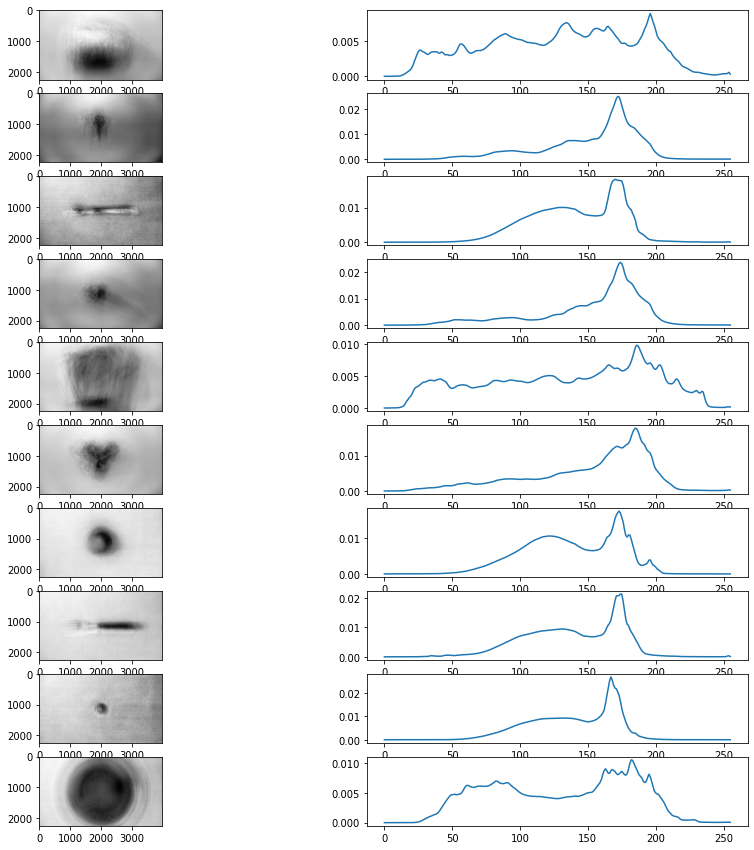

In [ ]:
eixoX=np.linspace(0,255,num=256)

fig, ax = plt.subplots(10,2,figsize=(15, 15))
ax[0,0].imshow(caneca_med_gry,cmap="Greys_r")
ax[0,1].plot(eixoX,hist_caneca_med_gry)
ax[1,0].imshow(chave_med_gry,cmap="Greys_r")
ax[1,1].plot(eixoX,hist_chave_med_gry)
ax[2,0].imshow(escova_med_gry,cmap="Greys_r")
ax[2,1].plot(eixoX,hist_escova_med_gry)
ax[3,0].imshow(dado_med_gry,cmap="Greys_r")
ax[3,1].plot(eixoX,hist_dado_med_gry)
ax[4,0].imshow(meia_med_gry,cmap="Greys_r")
ax[4,1].plot(eixoX,hist_meia_med_gry)
ax[5,0].imshow(fidget_med_gry,cmap="Greys_r")
ax[5,1].plot(eixoX,hist_fidget_med_gry)
ax[6,0].imshow(laranja_med_gry,cmap="Greys_r")
ax[6,1].plot(eixoX,hist_laranja_med_gry)
ax[7,0].imshow(garfo_med_gry,cmap="Greys_r")
ax[7,1].plot(eixoX,hist_garfo_med_gry)
ax[8,0].imshow(moeda_med_gry,cmap="Greys_r")
ax[8,1].plot(eixoX,hist_moeda_med_gry)
ax[9,0].imshow(prato_med_gry,cmap="Greys_r")
ax[9,1].plot(eixoX,hist_prato_med_gry)
plt.show()

## Medição do tamanho do dataset aumentado

Aqui mostramos as métricas do nosso dataset aumentado, que é a junção do GryData e do AugData, por isso contem 5400 imagens.

In [ ]:
coll_aug=len(imgs_aug.files)

tam_aug=0
for i in range(0,coll_aug):
  tam_aug=tam_aug+math.ceil(os.path.getsize(imgs_aug.files[i])/(1024*1024))

print(tabulate([['Número de classes', 10], 
                ['Número de imagens', coll_aug],
                ['Tamanho da base (MiB)', tam_aug],
                ['Resolução das imagens', f"{imgs_aug[0].shape[0]}x{imgs_aug[0].shape[1]}"]], 
               headers=['Aug Dataset', 'Valor'], tablefmt='pretty'))

+-----------------------+-----------+
|      Aug Dataset      |   Valor   |
+-----------------------+-----------+
|   Número de classes   |    10     |
|   Número de imagens   |   5400    |
| Tamanho da base (MiB) |   6855    |
| Resolução das imagens | 2248x4000 |
+-----------------------+-----------+


## Cálculo dos protótipos médios e histogramas médios para o dataset aumentado

Assim como fizemos para o dataset cinza, calculamos o protótipo médio e o histograma médio (média dos histogramas) para o dataset aumentado.

In [ ]:
caneca_med_aug=np.zeros(imgs_aug[0].shape)
chave_med_aug=np.zeros(imgs_aug[0].shape)
escova_med_aug=np.zeros(imgs_aug[0].shape)
dado_med_aug=np.zeros(imgs_aug[0].shape)
meia_med_aug=np.zeros(imgs_aug[0].shape)
fidget_med_aug=np.zeros(imgs_aug[0].shape)
laranja_med_aug=np.zeros(imgs_aug[0].shape)
garfo_med_aug=np.zeros(imgs_aug[0].shape)
moeda_med_aug=np.zeros(imgs_aug[0].shape)
prato_med_aug=np.zeros(imgs_aug[0].shape)

hist_caneca_med_aug=np.zeros(256)
hist_chave_med_aug=np.zeros(256)
hist_escova_med_aug=np.zeros(256)
hist_dado_med_aug=np.zeros(256)
hist_meia_med_aug=np.zeros(256)
hist_fidget_med_aug=np.zeros(256)
hist_laranja_med_aug=np.zeros(256)
hist_garfo_med_aug=np.zeros(256)
hist_moeda_med_aug=np.zeros(256)
hist_prato_med_aug=np.zeros(256)

n_canecas=0
n_chaves=0
n_escovas=0
n_dados=0
n_meias=0
n_fidgets=0
n_laranjas=0
n_garfos=0
n_moedas=0
n_pratos=0



for i in range(0,coll_aug):
  pathfull=os.path.splitext(imgs_aug.files[i])[0]
  nome=pathfull.split("/")[1]
  classe=(nome.split("_")[0])[:-1]
  if (classe == "Caneca") :
    caneca_med_aug=caneca_med_aug+imgs_aug[i]
    hist_caneca_med_aug=hist_caneca_med_aug+np.histogram(imgs_aug[i],bins=256,range=(0,255),normed=True)[0]
    n_canecas += 1
  elif (classe == "Chave") :
    chave_med_aug=chave_med_aug+imgs_aug[i]
    hist_chave_med_aug=hist_chave_med_aug+np.histogram(imgs_aug[i],bins=256,range=(0,255),normed=True)[0]
    n_chaves += 1
  elif (classe == "Escova") :
    escova_med_aug=escova_med_aug+imgs_aug[i]
    hist_escova_med_aug=hist_escova_med_aug+np.histogram(imgs_aug[i],bins=256,range=(0,255),normed=True)[0]
    n_escovas += 1
  elif (classe == "Dado") :
    dado_med_aug=dado_med_aug+imgs_aug[i]
    hist_dado_med_aug=hist_dado_med_aug+np.histogram(imgs_aug[i],bins=256,range=(0,255),normed=True)[0]
    n_dados += 1
  elif (classe == "Meia") :
    meia_med_aug=meia_med_aug+imgs_aug[i]
    hist_meia_med_aug=hist_meia_med_aug+np.histogram(imgs_aug[i],bins=256,range=(0,255),normed=True)[0]
    n_meias += 1
  elif (classe == "Fidget") :
    fidget_med_aug=fidget_med_aug+imgs_aug[i]
    hist_fidget_med_aug=hist_fidget_med_aug+np.histogram(imgs_aug[i],bins=256,range=(0,255),normed=True)[0]
    n_fidgets += 1
  elif (classe == "Laranja") :
    laranja_med_aug=laranja_med_aug+imgs_aug[i]
    hist_laranja_med_aug=hist_laranja_med_aug+np.histogram(imgs_aug[i],bins=256,range=(0,255),normed=True)[0]
    n_laranjas += 1
  elif (classe == "Garfo") :
    garfo_med_aug=garfo_med_aug+imgs_aug[i]
    hist_garfo_med_aug=hist_garfo_med_aug+np.histogram(imgs_aug[i],bins=256,range=(0,255),normed=True)[0]
    n_garfos += 1
  elif (classe == "Moeda") :
    moeda_med_aug=moeda_med_aug+imgs_aug[i]
    hist_moeda_med_aug=hist_moeda_med_aug+np.histogram(imgs_aug[i],bins=256,range=(0,255),normed=True)[0]
    n_moedas += 1
  elif (classe == "Prato") :
    prato_med_aug=prato_med_aug+imgs_aug[i]
    hist_prato_med_aug=hist_prato_med_aug+np.histogram(imgs_aug[i],bins=256,range=(0,255),normed=True)[0]
    n_pratos += 1

caneca_med_aug=caneca_med_aug/n_canecas
chave_med_aug=chave_med_aug/n_chaves
escova_med_aug=escova_med_aug/n_escovas
dado_med_aug=dado_med_aug/n_dados
meia_med_aug=meia_med_aug/n_meias
fidget_med_aug=fidget_med_aug/n_fidgets
laranja_med_aug=laranja_med_aug/n_laranjas
garfo_med_aug=garfo_med_aug/n_garfos
moeda_med_aug=moeda_med_aug/n_moedas
prato_med_aug=prato_med_aug/n_pratos

hist_caneca_med_aug=hist_caneca_med_aug/n_canecas
hist_chave_med_aug=hist_chave_med_aug/n_chaves
hist_escova_med_aug=hist_escova_med_aug/n_escovas
hist_dado_med_aug=hist_dado_med_aug/n_dados
hist_meia_med_aug=hist_meia_med_aug/n_meias
hist_fidget_med_aug=hist_fidget_med_aug/n_fidgets
hist_laranja_med_aug=hist_laranja_med_aug/n_laranjas
hist_garfo_med_aug=hist_garfo_med_aug/n_garfos
hist_moeda_med_aug=hist_moeda_med_aug/n_moedas
hist_prato_med_aug=hist_prato_med_aug/n_pratos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes nei

## Plot dos protótipos médios e histogramas médios para o dataset aumentado

Obs: As escalas verticais dos histogramas não são as mesmas por motivos estéticos.

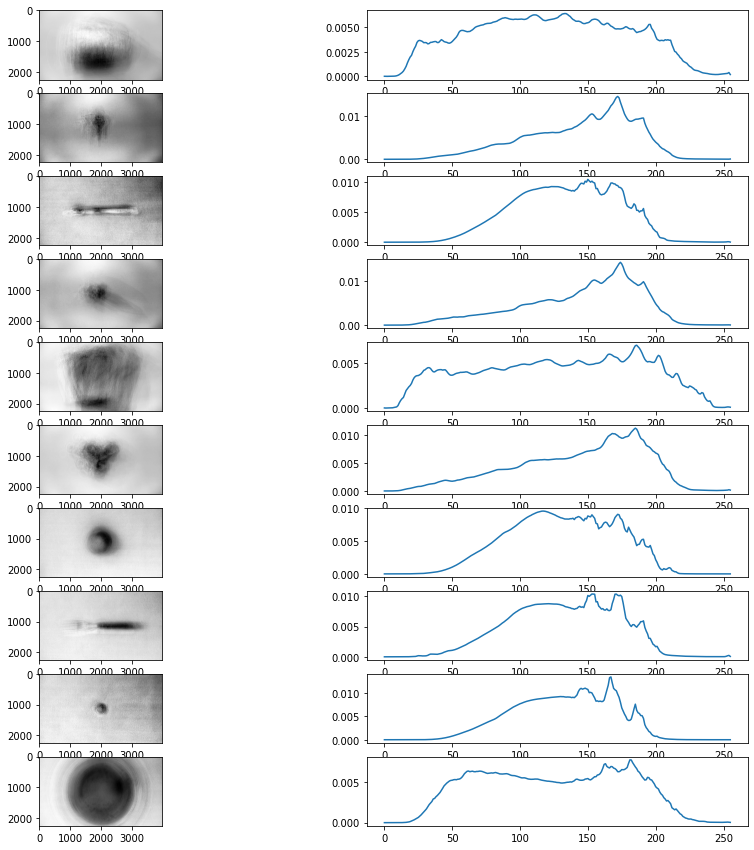

In [ ]:
fig, ax = plt.subplots(10,2,figsize=(15, 15))
ax[0,0].imshow(caneca_med_aug,cmap="Greys_r")
ax[0,1].plot(eixoX,hist_caneca_med_aug)
ax[1,0].imshow(chave_med_aug,cmap="Greys_r")
ax[1,1].plot(eixoX,hist_chave_med_aug)
ax[2,0].imshow(escova_med_aug,cmap="Greys_r")
ax[2,1].plot(eixoX,hist_escova_med_aug)
ax[3,0].imshow(dado_med_aug,cmap="Greys_r")
ax[3,1].plot(eixoX,hist_dado_med_aug)
ax[4,0].imshow(meia_med_aug,cmap="Greys_r")
ax[4,1].plot(eixoX,hist_meia_med_aug)
ax[5,0].imshow(fidget_med_aug,cmap="Greys_r")
ax[5,1].plot(eixoX,hist_fidget_med_aug)
ax[6,0].imshow(laranja_med_aug,cmap="Greys_r")
ax[6,1].plot(eixoX,hist_laranja_med_aug)
ax[7,0].imshow(garfo_med_aug,cmap="Greys_r")
ax[7,1].plot(eixoX,hist_garfo_med_aug)
ax[8,0].imshow(moeda_med_aug,cmap="Greys_r")
ax[8,1].plot(eixoX,hist_moeda_med_aug)
ax[9,0].imshow(prato_med_aug,cmap="Greys_r")
ax[9,1].plot(eixoX,hist_prato_med_aug)
plt.show()

## Equalização do dataset aumentado

Aqui calculamos o dataset normalizado sobre o dataset aumentado e salvamos no NormData.

In [ ]:
#################################
#POR FAVOR NAO RODE ISSO DE NOVO#
#################################
for i in range(0,coll_aug):
  pt=os.path.splitext(imgs_aug.files[i])[0]
  nome=pt.split("/")[1]
  #Normalize
  norm=exposure.equalize_hist(imgs_aug[i])
  io.imsave("NormData/"+nome+"_normd.jpg",norm)

A saída de streaming foi truncada nas últimas 5000 linhas.


## Medição do tamanho do dataset normalizado

Mostramos as métricas do NormData.

In [ ]:
imgs_norm = io.imread_collection("NormData/*.jpg")
coll_norm=len(imgs_norm.files)

tam_norm=0
for i in range(0,coll_norm):
  tam_norm=tam_norm+math.ceil(os.path.getsize(imgs_norm.files[i])/(1024*1024))

print(tabulate([['Número de classes', 10], 
                ['Número de imagens', coll_norm],
                ['Tamanho da base (MiB)', tam_norm],
                ['Resolução das imagens', f"{imgs_norm[0].shape[0]}x{imgs_norm[0].shape[1]}"]], 
               headers=['Nomred Dataset', 'Valor'], tablefmt='pretty'))

+-----------------------+-----------+
|    Nomred Dataset     |   Valor   |
+-----------------------+-----------+
|   Número de classes   |    10     |
|   Número de imagens   |   5400    |
| Tamanho da base (MiB) |   8803    |
| Resolução das imagens | 2248x4000 |
+-----------------------+-----------+


## Cálculo dos protótipos médios e histogramas médios para o dataset normalizado

Constam os mesmos cálculos feitos antes, mas para nosso novo dataset normalizado. 

In [ ]:
caneca_med_norm=np.zeros(imgs_norm[0].shape)
chave_med_norm=np.zeros(imgs_norm[0].shape)
escova_med_norm=np.zeros(imgs_norm[0].shape)
dado_med_norm=np.zeros(imgs_norm[0].shape)
meia_med_norm=np.zeros(imgs_norm[0].shape)
fidget_med_norm=np.zeros(imgs_norm[0].shape)
laranja_med_norm=np.zeros(imgs_norm[0].shape)
garfo_med_norm=np.zeros(imgs_norm[0].shape)
moeda_med_norm=np.zeros(imgs_norm[0].shape)
prato_med_norm=np.zeros(imgs_norm[0].shape)

hist_caneca_med_norm=np.zeros(256)
hist_chave_med_norm=np.zeros(256)
hist_escova_med_norm=np.zeros(256)
hist_dado_med_norm=np.zeros(256)
hist_meia_med_norm=np.zeros(256)
hist_fidget_med_norm=np.zeros(256)
hist_laranja_med_norm=np.zeros(256)
hist_garfo_med_norm=np.zeros(256)
hist_moeda_med_norm=np.zeros(256)
hist_prato_med_norm=np.zeros(256)

n_canecas=0
n_chaves=0
n_escovas=0
n_dados=0
n_meias=0
n_fidgets=0
n_laranjas=0
n_garfos=0
n_moedas=0
n_pratos=0



for i in range(0,coll_norm):
  pathfull=os.path.splitext(imgs_norm.files[i])[0]
  nome=pathfull.split("/")[1]
  classe=(nome.split("_")[0])[:-1]
  if (classe == "Caneca") :
    caneca_med_norm=caneca_med_norm+imgs_norm[i]
    hist_caneca_med_norm=hist_caneca_med_norm+np.histogram(imgs_norm[i],bins=256,range=(0,255),normed=True)[0]
    n_canecas += 1
  elif (classe == "Chave") :
    chave_med_norm=chave_med_norm+imgs_norm[i]
    hist_chave_med_norm=hist_chave_med_norm+np.histogram(imgs_norm[i],bins=256,range=(0,255),normed=True)[0]
    n_chaves += 1
  elif (classe == "Escova") :
    escova_med_norm=escova_med_norm+imgs_norm[i]
    hist_escova_med_norm=hist_escova_med_norm+np.histogram(imgs_norm[i],bins=256,range=(0,255),normed=True)[0]
    n_escovas += 1
  elif (classe == "Dado") :
    dado_med_norm=dado_med_norm+imgs_norm[i]
    hist_dado_med_norm=hist_dado_med_norm+np.histogram(imgs_norm[i],bins=256,range=(0,255),normed=True)[0]
    n_dados += 1
  elif (classe == "Meia") :
    meia_med_norm=meia_med_norm+imgs_norm[i]
    hist_meia_med_norm=hist_meia_med_norm+np.histogram(imgs_norm[i],bins=256,range=(0,255),normed=True)[0]
    n_meias += 1
  elif (classe == "Fidget") :
    fidget_med_norm=fidget_med_norm+imgs_norm[i]
    hist_fidget_med_norm=hist_fidget_med_norm+np.histogram(imgs_norm[i],bins=256,range=(0,255),normed=True)[0]
    n_fidgets += 1
  elif (classe == "Laranja") :
    laranja_med_norm=laranja_med_norm+imgs_norm[i]
    hist_laranja_med_norm=hist_laranja_med_norm+np.histogram(imgs_norm[i],bins=256,range=(0,255),normed=True)[0]
    n_laranjas += 1
  elif (classe == "Garfo") :
    garfo_med_norm=garfo_med_norm+imgs_norm[i]
    hist_garfo_med_norm=hist_garfo_med_norm+np.histogram(imgs_norm[i],bins=256,range=(0,255),normed=True)[0]
    n_garfos += 1
  elif (classe == "Moeda") :
    moeda_med_norm=moeda_med_norm+imgs_norm[i]
    hist_moeda_med_norm=hist_moeda_med_norm+np.histogram(imgs_norm[i],bins=256,range=(0,255),normed=True)[0]
    n_moedas += 1
  elif (classe == "Prato") :
    prato_med_norm=prato_med_norm+imgs_norm[i]
    hist_prato_med_norm=hist_prato_med_norm+np.histogram(imgs_norm[i],bins=256,range=(0,255),normed=True)[0]
    n_pratos += 1

caneca_med_norm=caneca_med_norm/n_canecas
chave_med_norm=chave_med_norm/n_chaves
escova_med_norm=escova_med_norm/n_escovas
dado_med_norm=dado_med_norm/n_dados
meia_med_norm=meia_med_norm/n_meias
fidget_med_norm=fidget_med_norm/n_fidgets
laranja_med_norm=laranja_med_norm/n_laranjas
garfo_med_norm=garfo_med_norm/n_garfos
moeda_med_norm=moeda_med_norm/n_moedas
prato_med_norm=prato_med_norm/n_pratos

hist_caneca_med_norm=hist_caneca_med_norm/n_canecas
hist_chave_med_norm=hist_chave_med_norm/n_chaves
hist_escova_med_norm=hist_escova_med_norm/n_escovas
hist_dado_med_norm=hist_dado_med_norm/n_dados
hist_meia_med_norm=hist_meia_med_norm/n_meias
hist_fidget_med_norm=hist_fidget_med_norm/n_fidgets
hist_laranja_med_norm=hist_laranja_med_norm/n_laranjas
hist_garfo_med_norm=hist_garfo_med_norm/n_garfos
hist_moeda_med_norm=hist_moeda_med_norm/n_moedas
hist_prato_med_norm=hist_prato_med_norm/n_pratos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes nei

## Plot dos protótipos médios e histogramas médios para o dataset normalizado

Obs: As escalas verticais dos histogramas não são iguais.

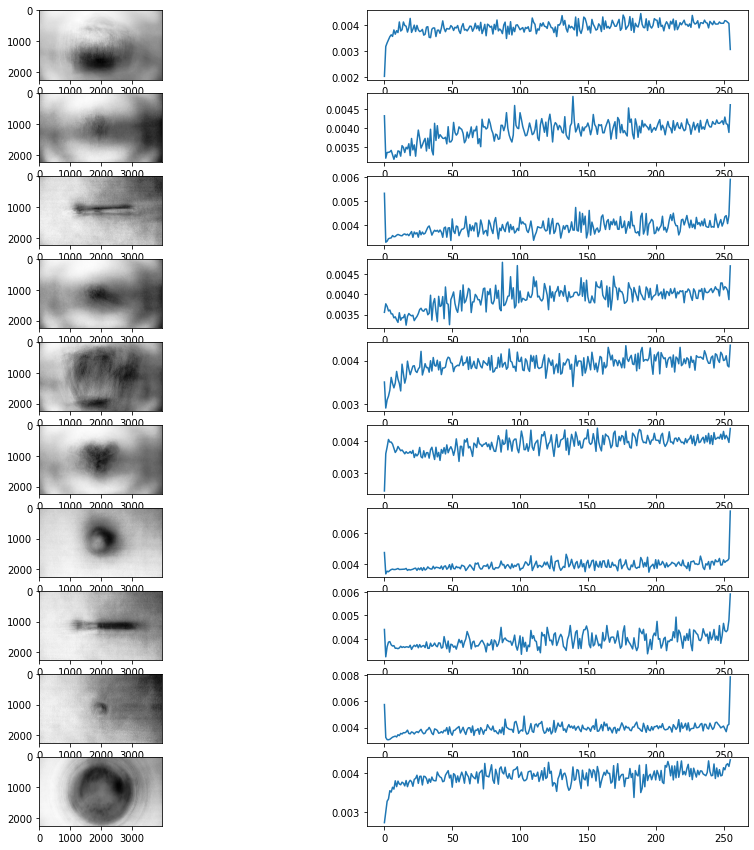

In [ ]:
fig, ax = plt.subplots(10,2,figsize=(15, 15))
ax[0,0].imshow(caneca_med_norm,cmap="Greys_r")
ax[0,1].plot(eixoX,hist_caneca_med_norm)
ax[1,0].imshow(chave_med_norm,cmap="Greys_r")
ax[1,1].plot(eixoX,hist_chave_med_norm)
ax[2,0].imshow(escova_med_norm,cmap="Greys_r")
ax[2,1].plot(eixoX,hist_escova_med_norm)
ax[3,0].imshow(dado_med_norm,cmap="Greys_r")
ax[3,1].plot(eixoX,hist_dado_med_norm)
ax[4,0].imshow(meia_med_norm,cmap="Greys_r")
ax[4,1].plot(eixoX,hist_meia_med_norm)
ax[5,0].imshow(fidget_med_norm,cmap="Greys_r")
ax[5,1].plot(eixoX,hist_fidget_med_norm)
ax[6,0].imshow(laranja_med_norm,cmap="Greys_r")
ax[6,1].plot(eixoX,hist_laranja_med_norm)
ax[7,0].imshow(garfo_med_norm,cmap="Greys_r")
ax[7,1].plot(eixoX,hist_garfo_med_norm)
ax[8,0].imshow(moeda_med_norm,cmap="Greys_r")
ax[8,1].plot(eixoX,hist_moeda_med_norm)
ax[9,0].imshow(prato_med_norm,cmap="Greys_r")
ax[9,1].plot(eixoX,hist_prato_med_norm)
plt.show()

## Cálculo das variâncias dos histogramas médios para cada dataset por classe

Aqui calcula-se a variância dos histogramas apresentados para os diferentes datasets.

In [ ]:
print(tabulate([["Caneca", f"{np.var(hist_caneca_med_gry*eixoX)}", f"{np.var(hist_caneca_med_aug*eixoX)}", f"{np.var(hist_caneca_med_norm*eixoX)}"],
                ["Chave",  f"{np.var(hist_chave_med_gry*eixoX)}", f"{np.var(hist_chave_med_aug*eixoX)}", f"{np.var(hist_chave_med_norm*eixoX)}"],
                ["Escova", f"{np.var(hist_escova_med_gry*eixoX)}", f"{np.var(hist_escova_med_aug*eixoX)}", f"{np.var(hist_escova_med_norm*eixoX)}"],
                ["Dado",  f"{np.var(hist_dado_med_gry*eixoX)}", f"{np.var(hist_dado_med_aug*eixoX)}", f"{np.var(hist_dado_med_norm*eixoX)}"],
                ["Meia",  f"{np.var(hist_meia_med_gry*eixoX)}", f"{np.var(hist_meia_med_aug*eixoX)}", f"{np.var(hist_meia_med_norm*eixoX)}"],
                ["Fidget", f"{np.var(hist_fidget_med_gry*eixoX)}", f"{np.var(hist_fidget_med_aug*eixoX)}", f"{np.var(hist_fidget_med_norm*eixoX)}"],
                ["Laranja", f"{np.var(hist_laranja_med_gry*eixoX)}", f"{np.var(hist_laranja_med_aug*eixoX)}", f"{np.var(hist_laranja_med_norm*eixoX)}"],
                ["Garfo", f"{np.var(hist_garfo_med_gry*eixoX)}", f"{np.var(hist_garfo_med_aug*eixoX)}", f"{np.var(hist_garfo_med_norm*eixoX)}"],
                ["Moeada", f"{np.var(hist_moeda_med_gry*eixoX)}", f"{np.var(hist_moeda_med_aug*eixoX)}", f"{np.var(hist_moeda_med_norm*eixoX)}"],
                ["Prato",  f"{np.var(hist_prato_med_gry*eixoX)}", f"{np.var(hist_prato_med_aug*eixoX)}", f"{np.var(hist_prato_med_norm*eixoX)}"]], 
               headers=['Nome da classe', "Dataset Cinza","Dataset Aumentado","Dataset Normalizado"], tablefmt='pretty'))


+----------------+---------------------+---------------------+---------------------+
| Nome da classe |    Dataset Cinza    |  Dataset Aumentado  | Dataset Normalizado |
+----------------+---------------------+---------------------+---------------------+
|     Caneca     | 0.16428279718368982 | 0.10649618981727063 | 0.09108715250237504 |
|     Chave      |  0.866628497240913  | 0.43649451810524104 | 0.09341561679068217 |
|     Escova     | 0.5817765960102206  | 0.31314559110679097 | 0.09674078102166404 |
|      Dado      |  0.870174143268867  | 0.4431482616892524  | 0.09318439064173573 |
|      Meia      | 0.18686911168005016 | 0.12399591411102533 | 0.09035716513119763 |
|     Fidget     | 0.6338610810027753  | 0.34927910289775976 | 0.09351729430405398 |
|    Laranja     | 0.4732110134439436  | 0.26822790738937485 | 0.09823957058431362 |
|     Garfo      | 0.5939947205106949  | 0.2967590857708979  | 0.09910421798712066 |
|     Moeada     | 0.7434128066525124  |  0.349206110014546  | 0.